# Linear Regression Modelling on House Sales Price

Table of Content:
* [Load Library and Dataset](#load)
* [Handle Missing Values](#missing)
* [Exploratory Data Analysis](#eda)
* [Box-Cox Transformation of the Sales Price](#boxcox)
* [Linear Regression p-value forward selection](#lr)
    1. <a href='#step1'>Step 1 - Initial Model</a>
    2. [Step 2](#Step2)
    3. [Step 3](#Step3)
    4. [Step 4](#Step4)
    5. [Step 5](#Step5)
    6. [Step 6](#Step6)

<a id=load></a>
# Load Library and Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import outliers_influence as sms_outliers
from sklearn.model_selection import train_test_split
from scipy import stats

In [2]:
train0 = pd.read_csv('.//datasets//train.csv', header=0)
test = pd.read_csv('.//datasets//test.csv', header=0)
submission_sample = pd.read_csv('.//datasets//sample_submission.csv', header=0)

In [3]:
train0.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
train0.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  ScreenPorch  \
count  1460.000000  1460.000000    1460.000000  1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110     3.409589    15.060959   
std     125.338794    66.256028      61.119149    29.317331    55.757415   
min       0.000000     0.000000       0.000000     0.000000     0.000000   
25%       0.000000     0.000000       0.000000     0.000000     0.000000   
50%       0.000000    25.000000       0.000000     0.000000     0.000000   
75%     168.000000    68.000000       0.000000     0.000000     0.000000   
max     857.000000   547.000000     552.000000   508.000000   480.000000   

          PoolArea       MiscVal       MoSold       YrSold      SalePrice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

In [5]:
profile_train = ProfileReport(train0, title='Profiling Report of Trainig Data', minimal=True)

In [6]:
profile_train.to_html()

<a id='missing'></a>
# Missing Values

Based on the Pandas Profiling Report and Data Description, there are some variables with high percentage of missing values. However, we can't just blindly remove the missing values or impute them. We also need to consider the modelling approach we are going to use. Linear regression methods do not like missing values, so if we decide to use this we might consider imputing or removing the missing values. If we use random forests or XGBoost, we can keep the missing values but we still need to have a good reason for it. 
* Some categorical variables with missing values are actually important and should not be treated as nulls. For example, we can see that `BsmtQual` (Basement Quality) with NA value means the house has no basement. This is also reflected in `TotalBsmtSF` with zero values (again no basement). Therefore, we have to create a specific category for no Basement so it will not be detected as nulls. 
* Due to the large percentage of missing values (more than 80%), we might need to consider removing `Alley`, `PoolQC`, `Fence`, and `MiscFeature` from our features. However, we need to ensure this by observing the boxplots of each category against the target variable, which is `SalePrice`.
* One numerical variable which is `LotFrontage` has a missing value. Based on the data description, this measures the linear feet of street connected to property. We might consider imputing this with simple methods like median or mean.

In [5]:
train_ = train0.copy()
train_['PoolQC'] = np.where(pd.isnull(train_['PoolQC']), 'Na', train_['PoolQC'])
train_['Alley'] = np.where(pd.isnull(train_['Alley']), 'Na', train_['Alley'])
train_['MiscFeature'] = np.where(pd.isnull(train_['MiscFeature']), 'Na', train_['MiscFeature'])
train_['Fence'] = np.where(pd.isnull(train_['Fence']), 'Na', train_['Fence'])
train_['FireplaceQu'] = np.where(pd.isnull(train_['FireplaceQu']), 'Na', train_['FireplaceQu'])

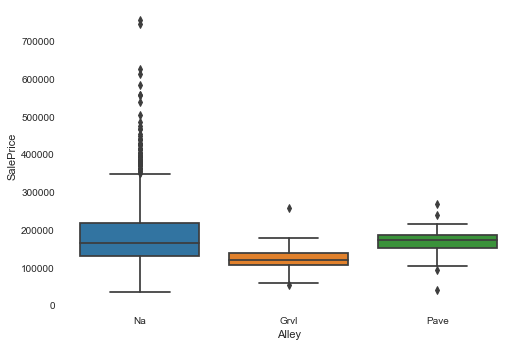

In [6]:
sns.boxplot(x='Alley', y='SalePrice', data=train_)

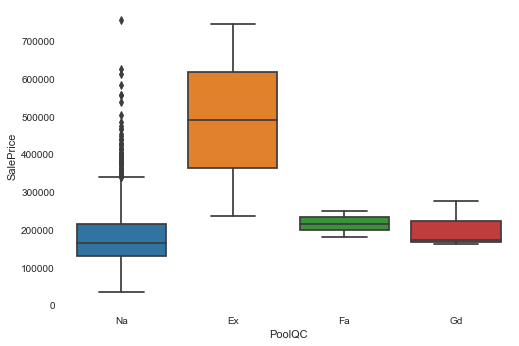

In [7]:
sns.boxplot(x='PoolQC', y='SalePrice', data=train_)

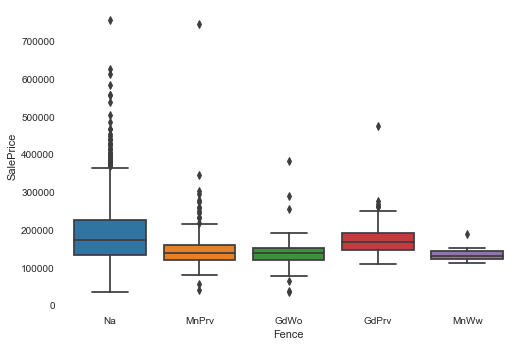

In [8]:
sns.boxplot(x='Fence', y='SalePrice', data=train_)

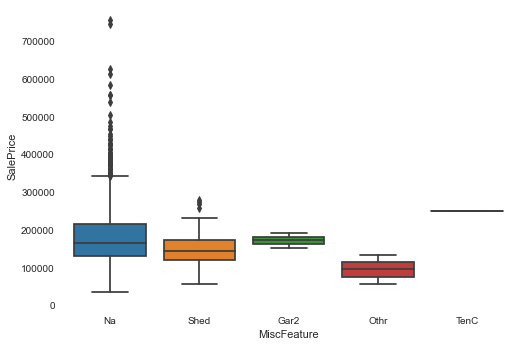

In [9]:
sns.boxplot(x='MiscFeature', y='SalePrice', data=train_)

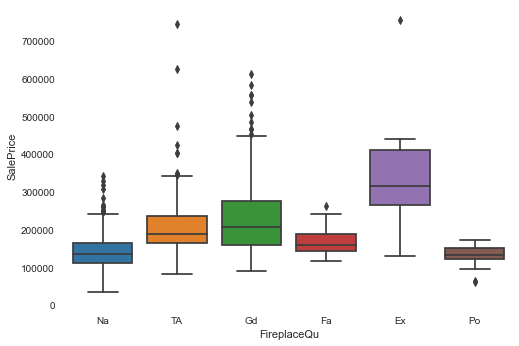

In [10]:
sns.boxplot(x='FireplaceQu', y='SalePrice', data=train_)

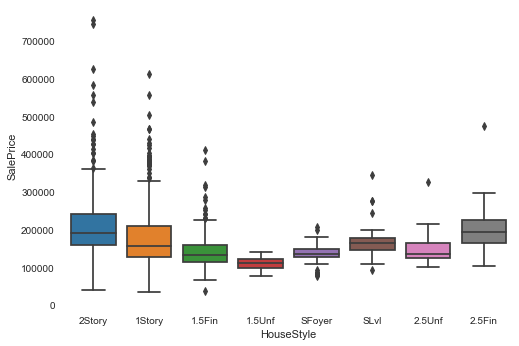

In [95]:
sns.boxplot(x='HouseStyle', y='SalePrice', data=train_)

In [11]:
missing_features = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                    'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

In [14]:
test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

<a id='eda'></a>
# Exploratory Data Analysis

In [12]:
train0['AgeBuilt'] = train0['YrSold'] - train0['YearBuilt']
train0['AgeRemodAdd'] = train0['YrSold'] - train0['YearRemodAdd']

In [13]:
numerical_features = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'AgeBuilt',
                      'AgeRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                     '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
                     'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
                     'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                     '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

In [14]:
train0[numerical_features].corr()

LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
LotFrontage       1.000000  0.426095     0.251646    -0.059213   0.123349   
LotArea           0.426095  1.000000     0.105806    -0.005636   0.014228   
OverallQual       0.251646  0.105806     1.000000    -0.091932   0.572323   
OverallCond      -0.059213 -0.005636    -0.091932     1.000000  -0.375983   
YearBuilt         0.123349  0.014228     0.572323    -0.375983   1.000000   
YearRemodAdd      0.088866  0.013788     0.550684     0.073741   0.592855   
AgeBuilt         -0.122848 -0.014832    -0.572629     0.377325  -0.999036   
AgeRemodAdd      -0.088417 -0.014709    -0.552570    -0.070931  -0.593868   
MasVnrArea        0.193458  0.104160     0.411876    -0.128101   0.315707   
BsmtFinSF1        0.233633  0.214103     0.239666    -0.046231   0.249503   
BsmtFinSF2        0.049900  0.111170    -0.059119     0.040229  -0.049107   
BsmtUnfSF         0.132644 -0.002618     0.308159    -0.136841   0.149040   
TotalBsmtSF       0.392075  0.260833     0.537808    -0.171098   0.391452   
1stFlrSF          0.457181  0.299475     0.476224    -0.144203   0.281986   
2ndFlrSF          0.080177  0.050986     0.295493     0.028942   0.010308   
LowQualFinSF      0.038469  0.004779    -0.030429     0.025494  -0.183784   
GrLivArea         0.402797  0.263116     0.593007    -0.079686   0.199010   
BsmtFullBath      0.100949  0.158155     0.111098    -0.054942   0.187599   
BsmtHalfBath     -0.007234  0.048046    -0.040150     0.117821  -0.038162   
FullBath          0.198769  0.126031     0.550600    -0.194149   0.468271   
HalfBath          0.053532  0.014259     0.273458    -0.060769   0.242656   
TotRmsAbvGrd      0.352096  0.190015     0.427452    -0.057583   0.095589   
Fireplaces        0.266639  0.271364     0.396765    -0.023820   0.147716   
GarageYrBlt       0.070250 -0.024947     0.547766    -0.324297   0.825667   
GarageCars        0.285691  0.154871     0.600671    -0.185758   0.537850   
GarageArea        0.344997  0.180403     0.562022    -0.151521   0.478954   
WoodDeckSF        0.088521  0.171698     0.238923    -0.003334   0.224880   
OpenPorchSF       0.151972  0.084774     0.308819    -0.032589   0.188686   
EnclosedPorch     0.010700 -0.018340    -0.113937     0.070356  -0.387268   
3SsnPorch         0.070029  0.020423     0.030371     0.025504   0.031355   
ScreenPorch       0.041383  0.043160     0.064886     0.054811  -0.050364   
PoolArea          0.206167  0.077672     0.065166    -0.001985   0.004950   
MiscVal           0.003368  0.038068    -0.031406     0.068777  -0.034383   
MoSold            0.011200  0.001205     0.070815    -0.003511   0.012398   
YrSold            0.007450 -0.014261    -0.027347     0.043950  -0.013618   
SalePrice         0.351799  0.263843     0.790982    -0.077856   0.522897   

               YearRemodAdd  AgeBuilt  AgeRemodAdd  MasVnrArea  BsmtFinSF1  \
LotFrontage        0.088866 -0.122848    -0.088417    0.193458    0.233633   
LotArea            0.013788 -0.014832    -0.014709    0.104160    0.214103   
OverallQual        0.550684 -0.572629    -0.552570    0.411876    0.239666   
OverallCond        0.073741  0.377325    -0.070931   -0.128101   -0.046231   
YearBuilt          0.592855 -0.999036    -0.593868    0.315707    0.249503   
YearRemodAdd       1.000000 -0.590360    -0.997930    0.179618    0.128451   
AgeBuilt          -0.590360  1.000000     0.594195   -0.315562   -0.248483   
AgeRemodAdd       -0.997930  0.594195     1.000000   -0.180183   -0.127556   
MasVnrArea         0.179618 -0.315562    -0.180183    1.000000    0.264736   
BsmtFinSF1         0.128451 -0.248483    -0.127556    0.264736    1.000000   
BsmtFinSF2        -0.067759  0.050422     0.069814   -0.072319   -0.050117   
BsmtUnfSF          0.181133 -0.150619    -0.183830    0.114442   -0.495251   
TotalBsmtSF        0.291066 -0.391498    -0.292096    0.363936    0.522396   
1stFlrSF           0.240379 -0.282143    -0.241310    0.344501    0.44586

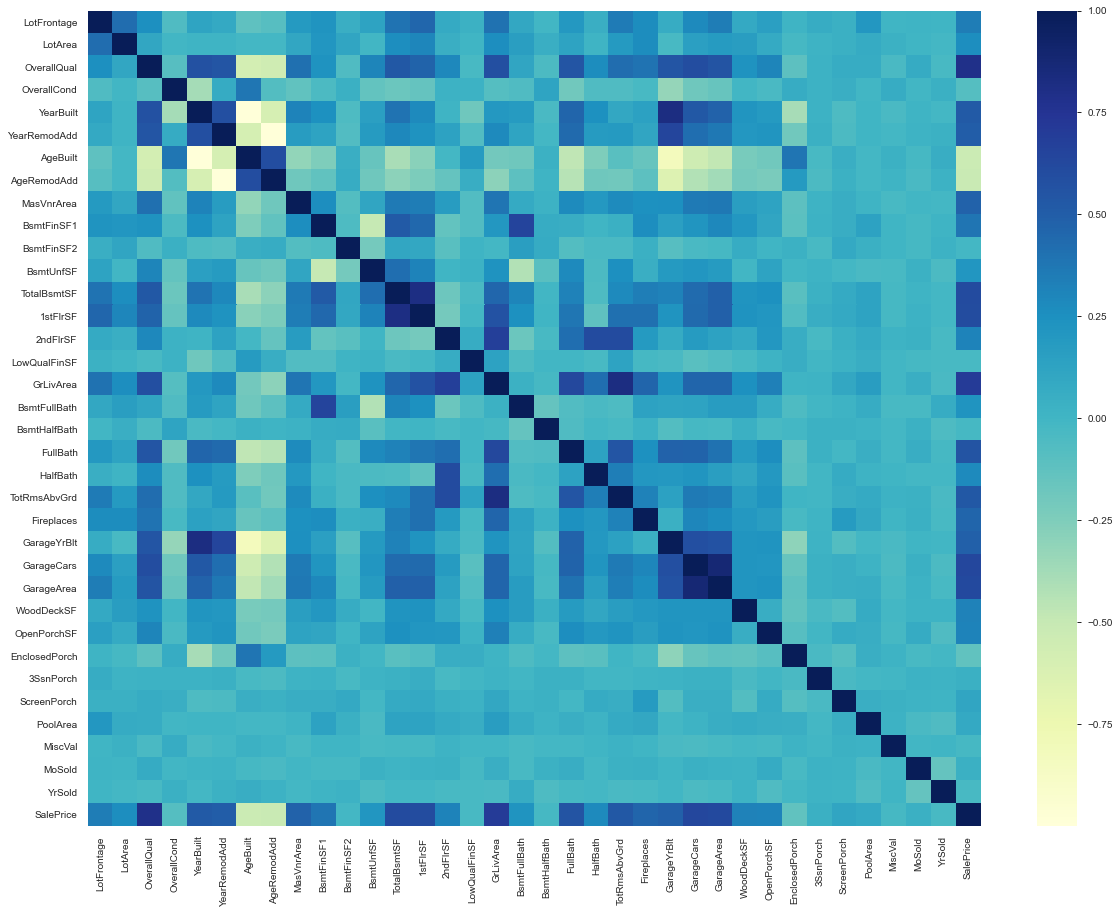

In [15]:
plt.subplots(figsize=(20,15))
sns.heatmap(train0[numerical_features].corr(), cmap="YlGnBu")

In [16]:
np.abs(train0[numerical_features].corr()['SalePrice']).sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
AgeBuilt         0.523350
YearBuilt        0.522897
AgeRemodAdd      0.509079
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
Name: SalePrice, dtype: float64

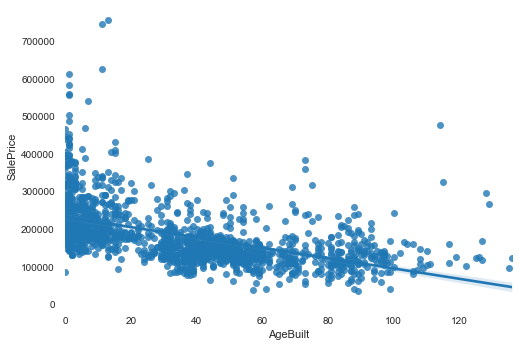

In [17]:
sns.regplot(x='AgeBuilt', y='SalePrice', data=train0)

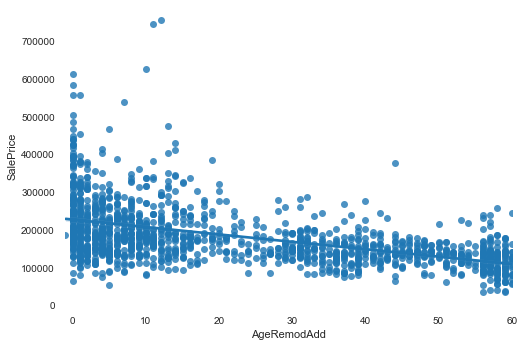

In [18]:
sns.regplot(x='AgeRemodAdd', y='SalePrice', data=train0)

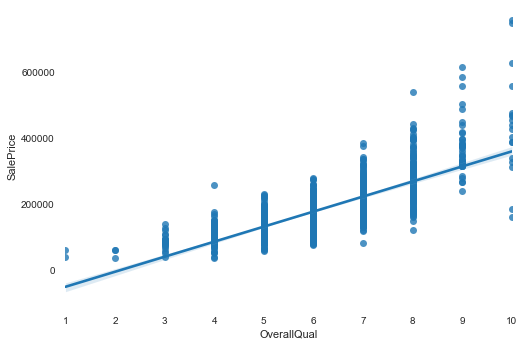

In [19]:
sns.regplot(x='OverallQual', y='SalePrice', data=train0)

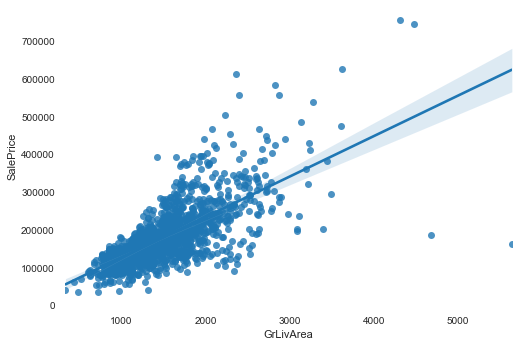

In [20]:
sns.regplot(x='GrLivArea', y='SalePrice', data=train0)

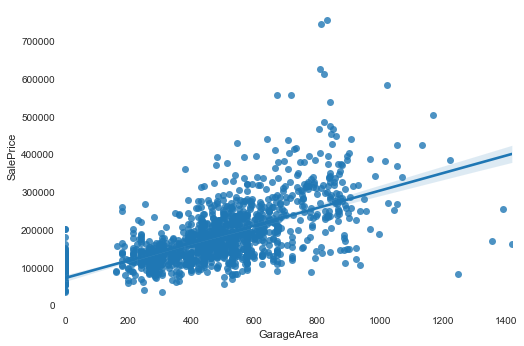

In [21]:
sns.regplot(x='GarageArea', y='SalePrice', data=train0)

# Box-Cox Transformation of the Dependent Variable

Based on the histogram below, the dependent vaiable or `SalePrice` has a right-skewed distribution. 

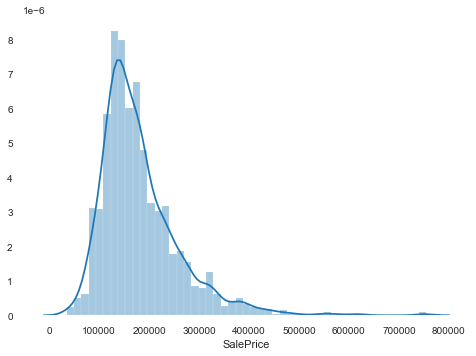

In [22]:
sns.distplot(train0.SalePrice)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

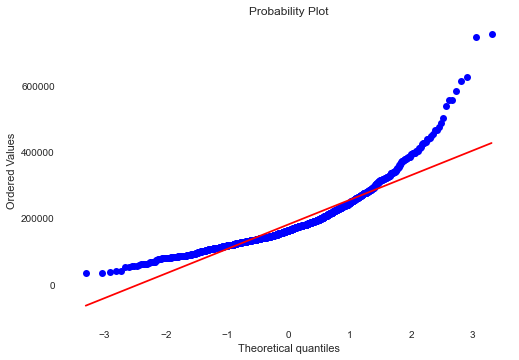

In [23]:
stats.probplot(train0.SalePrice, dist=stats.norm, plot=plt)

After the Box-Cox transformation, the distribution becomes normal.

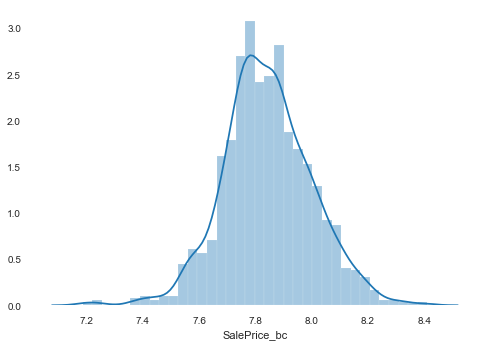

In [24]:
train0['SalePrice_bc'], _ = stats.boxcox(train0.SalePrice)
sns.distplot(train0.SalePrice_bc)

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([7.18570211, 7.19093599, 7.22246733, ..., 8.34295923, 8.40545244,
         8.41016236])),
 (0.15781082127181653, 7.842252009506654, 0.9955315707916029))

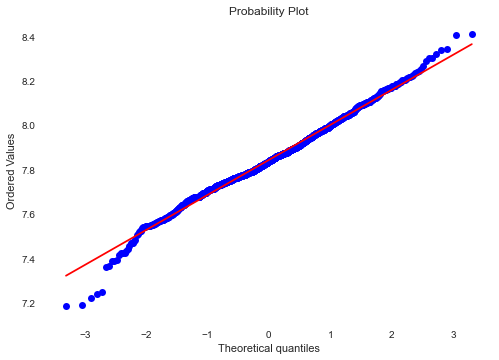

In [25]:
stats.probplot(train0['SalePrice_bc'], dist = stats.norm, plot=plt)

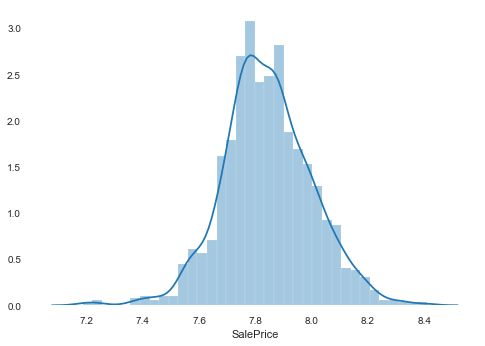

In [26]:
sns.distplot((train0.SalePrice**_ - 1) / _)

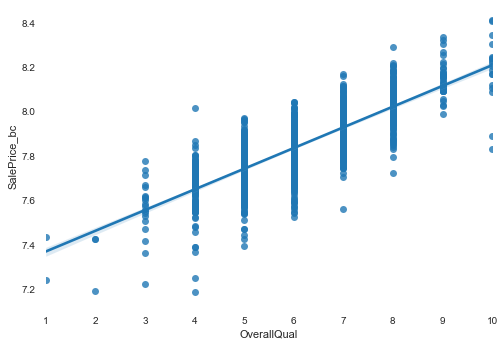

In [27]:
sns.regplot(x=train0.OverallQual, y=train0['SalePrice_bc'])

# Train Evaluate Split

In [28]:
X_train, X_eval, y_train, y_eval = train_test_split(train0.drop(columns=['SalePrice', 'SalePrice_bc']), train0.SalePrice_bc, 
                                                    train_size=0.7, random_state = True )

<a id='step1'></a>

# Linear Regression

## Step 1 - Initial Model

## Checking Conditions 

In [29]:
X_train1 = sm.add_constant(X_train['OverallQual'])
model1 = sm.OLS(endog=y_train, exog=X_train1)
result = model1.fit()

In [30]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePrice_bc   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     1883.
Date:                Thu, 28 May 2020   Prob (F-statistic):          8.12e-234
Time:                        14:40:22   Log-Likelihood:                 1015.2
No. Observations:                1021   AIC:                            -2026.
Df Residuals:                    1019   BIC:                            -2016.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2962      0.013    562.121      0.000       7.271       7.322
OverallQual     0.0898      0.002     43.394      0.000       0.086       0.094
==============================================================================
Omnibus:                       42.339   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.001
Skew:                          -0.341   Prob(JB):                     1.71e-15
Kurtosis:                       4.065   Cond. No.                         29.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 1. Linearity
The plots show that there is a linear relationship between the `OverallQual` and transformed `SalePrice` variable.

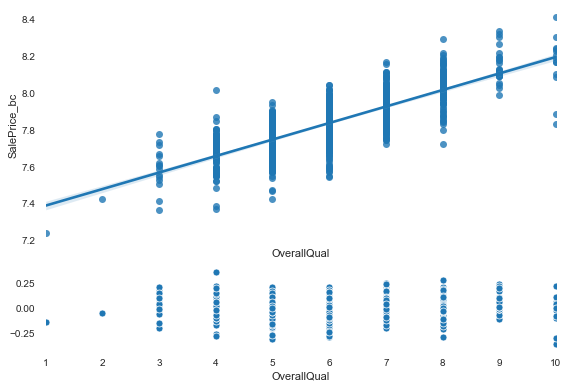

In [31]:
f, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
sns.regplot(x=X_train1['OverallQual'], y=y_train, ax=axes[0])
sns.scatterplot(x=X_train1.OverallQual, y=result.resid, ax=axes[1])
f.tight_layout()

### 2. Nearly normal distribution of the residuals
The residuals however are nearly normal distributed with slight skew to the left. 

((array([-3.20357641, -2.9388231 , -2.79110922, ...,  2.79110922,
          2.9388231 ,  3.20357641]),
  array([-0.36551264, -0.32196611, -0.30861069, ...,  0.24056062,
          0.27462323,  0.35671704])),
 (0.08912064668210405, -5.0941947363016e-15, 0.9927427208121024))

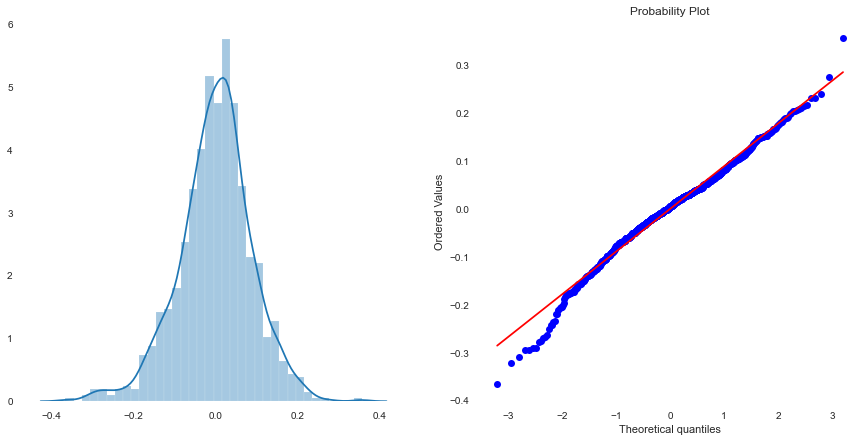

In [32]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.distplot(result.resid)
plt.subplot(1,2,2)
stats.probplot(result.resid, dist=stats.norm, plot=plt)

### 3. Constant variance of the residuals
The residuals as shown below indicate that they are homoscedastic. 

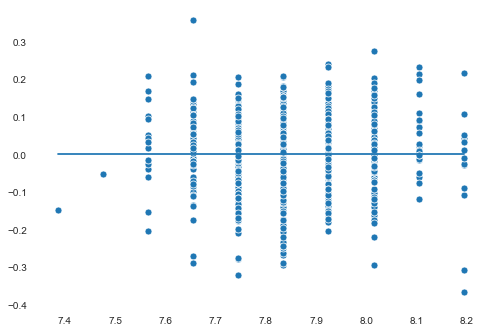

In [33]:
sns.scatterplot(x=result.fittedvalues, y=result.resid)
sns.lineplot(x=result.fittedvalues, y=0)

<a id ='Step2'></a>
## Step 2 

In [39]:
X_train2 = sm.add_constant(X_train[['OverallQual','GrLivArea']])
model2 = sm.OLS(endog=y_train, exog=X_train2)
result = model2.fit()

In [40]:
pd.Series([sms_outliers.variance_inflation_factor(exog = np.array(X_train2), exog_idx=i)
           for i in range(X_train2.shape[1])
          ], index=X_train2.columns)

const          21.462063
OverallQual     1.558558
GrLivArea       1.558558
dtype: float64

In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePrice_bc   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     1293.
Date:                Thu, 28 May 2020   Prob (F-statistic):          3.37e-280
Time:                        14:41:01   Log-Likelihood:                 1126.3
No. Observations:                1021   AIC:                            -2247.
Df Residuals:                    1018   BIC:                            -2232.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2880      0.012    625.112      0.000       7.265       7.311
OverallQual     0.0679      0.002     29.317      0.000       0.063       0.072
GrLivArea    9.333e-05   5.93e-06     15.734      0.000    8.17e-05       0.000
==============================================================================
Omnibus:                      330.372   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2306.808
Skew:                          -1.299   Prob(JB):                         0.00
Kurtosis:                       9.890   Cond. No.                     7.55e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

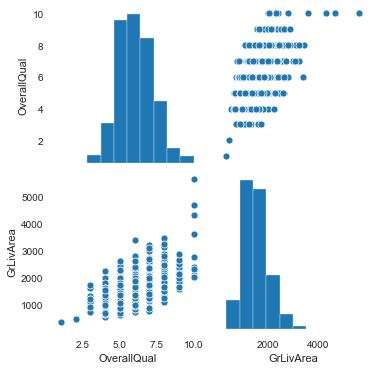

In [42]:
sns.pairplot(X_train2.drop(columns='const'))

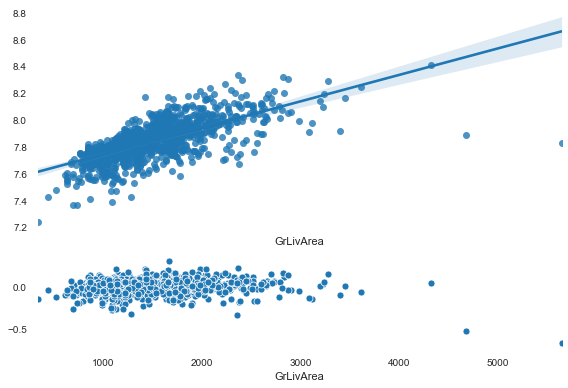

In [49]:
f, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [5, 2]})
sns.regplot(x=X_train2['GrLivArea'], y=y_train, ax=axes[0])
sns.scatterplot(x=X_train2.GrLivArea, y=result.resid, ax=axes[1])
f.tight_layout()

((array([-3.20357641, -2.9388231 , -2.79110922, ...,  2.79110922,
          2.9388231 ,  3.20357641]),
  array([-0.66560138, -0.51854008, -0.33222065, ...,  0.20888632,
          0.21515513,  0.29703453])),
 (0.07767786591594038, -1.171351621640169e-13, 0.964767948376775))

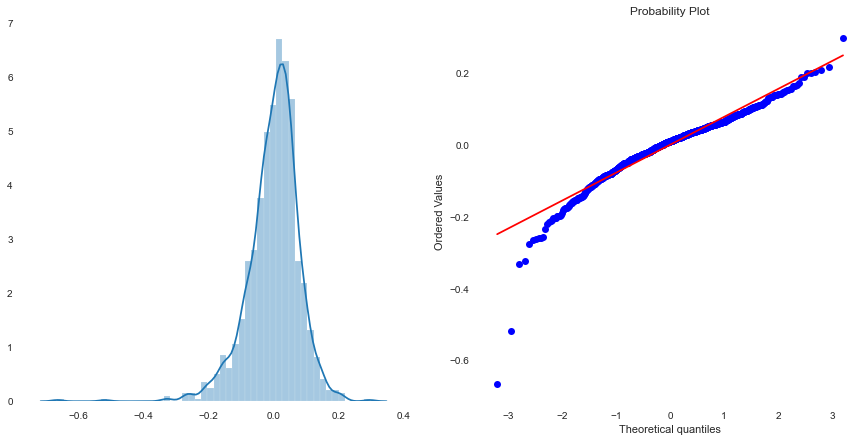

In [43]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.distplot(result.resid)
plt.subplot(1,2,2)
stats.probplot(result.resid, dist=stats.norm, plot=plt)

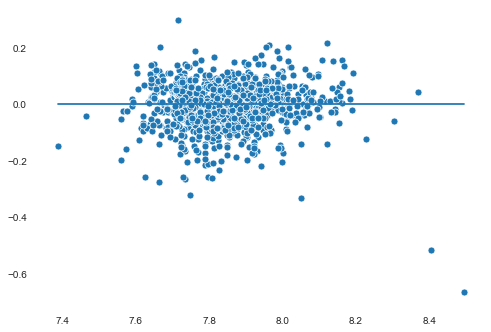

In [44]:
sns.scatterplot(x=result.fittedvalues, y=result.resid)
sns.lineplot(x=result.fittedvalues, y=0)

# Step 3

In [45]:
X_train3 = sm.add_constant(X_train[['OverallQual','GrLivArea', 'GarageCars']])
model3 = sm.OLS(endog=y_train, exog=X_train3)
result3 = model3.fit()

In [46]:
pd.Series([sms_outliers.variance_inflation_factor(exog = np.array(X_train3), exog_idx=i)
           for i in range(X_train3.shape[1])
          ], index=X_train3.columns)

const          21.532082
OverallQual     1.903225
GrLivArea       1.613346
GarageCars      1.563986
dtype: float64

In [47]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePrice_bc   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     1105.
Date:                Thu, 28 May 2020   Prob (F-statistic):          1.79e-319
Time:                        14:41:27   Log-Likelihood:                 1220.8
No. Observations:                1021   AIC:                            -2434.
Df Residuals:                    1017   BIC:                            -2414.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2967      0.011    685.125      0.000       7.276       7.318
OverallQual     0.0536      0.002     22.969      0.000       0.049       0.058
GrLivArea    7.874e-05    5.5e-06     14.306      0.000    6.79e-05    8.95e-05
GarageCars      0.0571      0.004     14.384      0.000       0.049       0.065
==============================================================================
Omnibus:                      264.167   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1571.089
Skew:                          -1.047   Prob(JB):                         0.00
Kurtosis:                       8.705   Cond. No.                     7.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

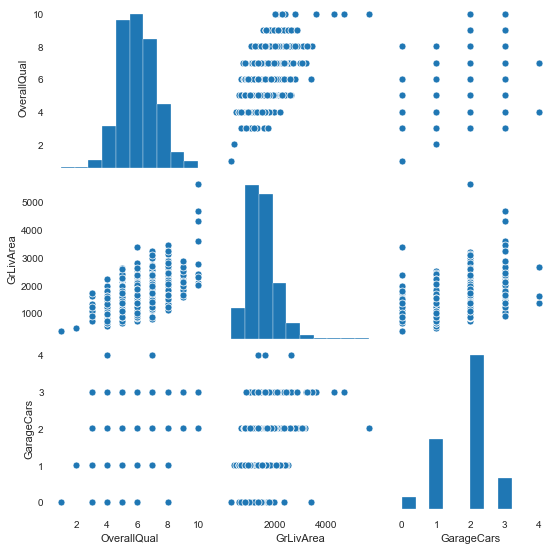

In [48]:
sns.pairplot(X_train3.drop(columns='const'))

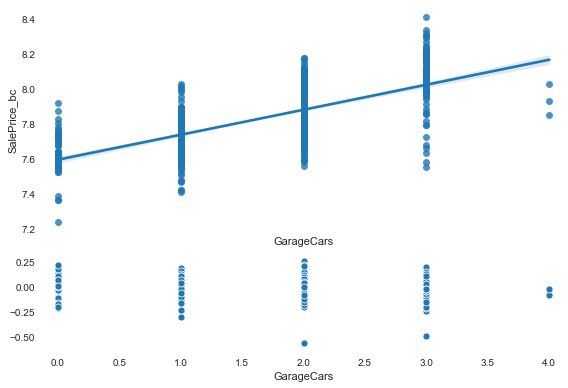

In [49]:
f, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [5, 2]})
plt.xlim(-0.1, 4.1)
sns.regplot(x=X_train3['GarageCars'], y=y_train, ax=axes[0])
sns.scatterplot(x=X_train3.GarageCars, y=result3.resid, ax=axes[1])
f.tight_layout()

((array([-3.20357641, -2.9388231 , -2.79110922, ...,  2.79110922,
          2.9388231 ,  3.20357641]),
  array([-0.56329861, -0.4874499 , -0.29945968, ...,  0.21337391,
          0.22098348,  0.25550825])),
 (0.07134866014731671, 4.043691054000061e-13, 0.9721288630357422))

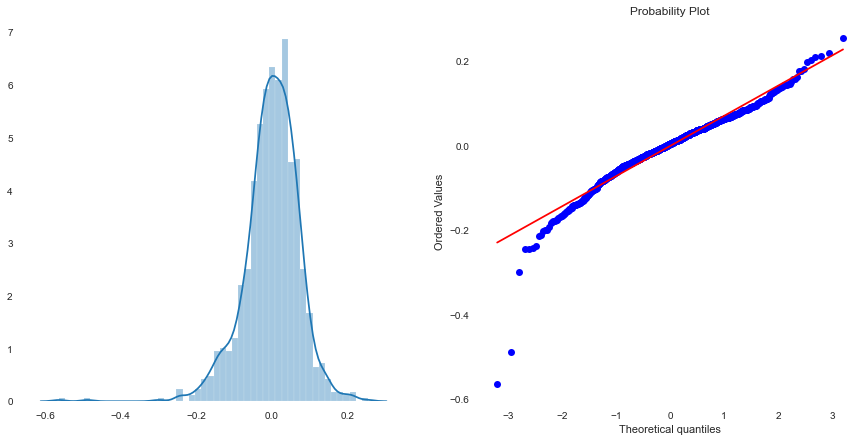

In [50]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.distplot(result3.resid)
plt.subplot(1,2,2)
stats.probplot(result3.resid, dist=stats.norm, plot=plt)

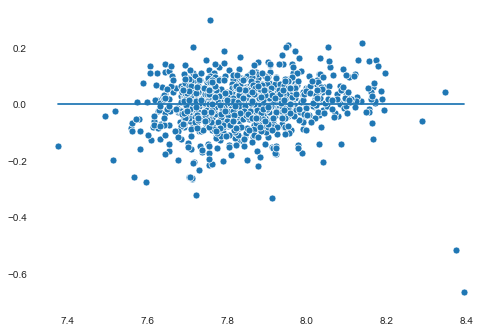

In [51]:
sns.scatterplot(x=result3.fittedvalues, y=result.resid)
sns.lineplot(x=result3.fittedvalues, y=0)

## Step 4 

In [52]:
X_train4 = sm.add_constant(X_train[['OverallQual','GrLivArea', 'GarageCars', 'GarageArea']])
model4 = sm.OLS(endog=y_train, exog=X_train4)
result4 = model4.fit()

In [53]:
pd.Series([sms_outliers.variance_inflation_factor(exog = np.array(X_train4), exog_idx=i)
           for i in range(X_train4.shape[1])
          ], index=X_train4.columns)

const          21.539782
OverallQual     1.903287
GrLivArea       1.642893
GarageCars      4.827408
GarageArea      4.601979
dtype: float64

In [54]:
X_train4 = sm.add_constant(X_train[['OverallQual','GrLivArea', 'GarageCars', 'TotalBsmtSF']])
model4 = sm.OLS(endog=y_train, exog=X_train4)
result4 = model4.fit()

In [55]:
pd.Series([sms_outliers.variance_inflation_factor(exog = np.array(X_train4), exog_idx=i)
           for i in range(X_train4.shape[1])
          ], index=X_train4.columns)

const          21.532448
OverallQual     2.067107
GrLivArea       1.662690
GarageCars      1.592838
TotalBsmtSF     1.465046
dtype: float64

In [32]:
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePrice_bc   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     902.5
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        14:40:13   Log-Likelihood:                 1254.7
No. Observations:                1021   AIC:                            -2499.
Df Residuals:                    1016   BIC:                            -2475.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2971      0.010    707.932      0.000       7.277       7.317
OverallQual     0.0481      0.002     20.421      0.000       0.043       0.053
GrLivArea    7.096e-05   5.41e-06     13.122      0.000    6.03e-05    8.16e-05
GarageCars      0.0528      0.004     13.603      0.000       0.045       0.060
TotalBsmtSF   5.01e-05      6e-06      8.352      0.000    3.83e-05    6.19e-05
==============================================================================
Omnibus:                      562.661   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12602.664
Skew:                          -2.048   Prob(JB):                         0.00
Kurtosis:                      19.717   Cond. No.                     9.15e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

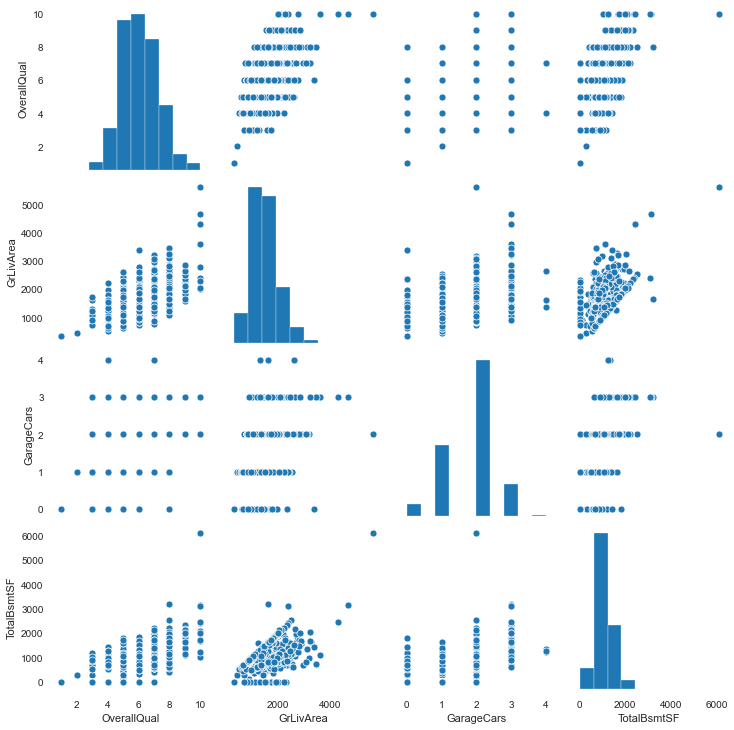

In [56]:
sns.pairplot(X_train4.drop(columns='const'))

<Figure size 576x396 with 0 Axes>

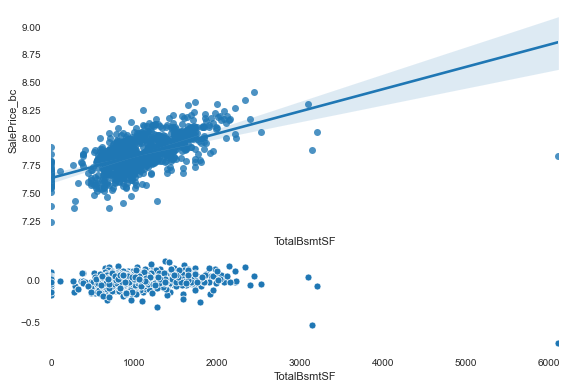

In [68]:
plt.clf()
f, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [5, 2]})
sns.regplot(x=X_train4['TotalBsmtSF'], y=y_train, ax=axes[0])
sns.scatterplot(x=X_train4.TotalBsmtSF, y=result4.resid, ax=axes[1])
f.tight_layout()

((array([-3.20357641, -2.9388231 , -2.79110922, ...,  2.79110922,
          2.9388231 ,  3.20357641]),
  array([-0.76178148, -0.54017827, -0.32176344, ...,  0.1899273 ,
          0.21360505,  0.23062648])),
 (0.06694960519003171, 3.7433284244662125e-13, 0.9429834742460345))

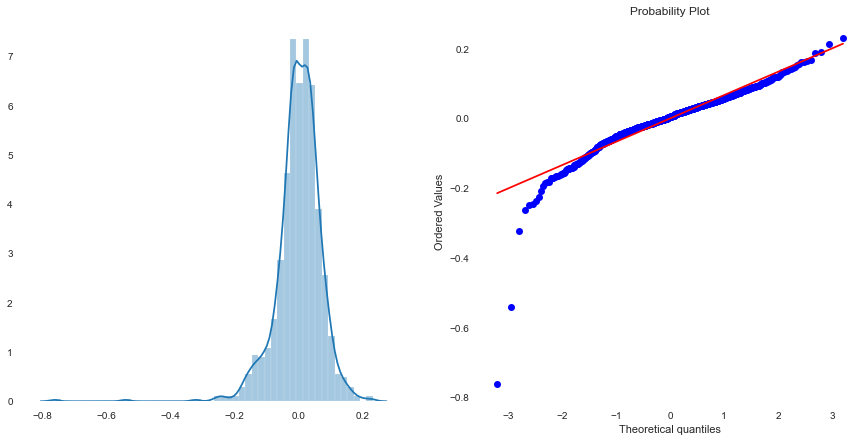

In [61]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.distplot(result4.resid)
plt.subplot(1,2,2)
stats.probplot(result4.resid, dist=stats.norm, plot=plt)

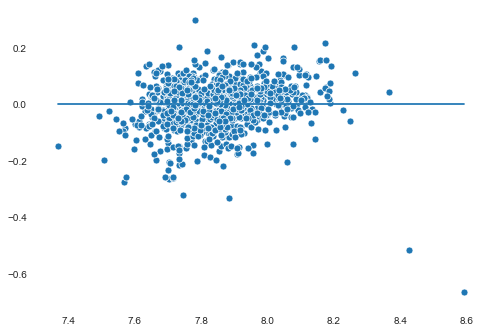

In [62]:
sns.scatterplot(x=result4.fittedvalues, y=result.resid)
sns.lineplot(x=result4.fittedvalues, y=0)

## Step 5 

In [72]:
X_train5 = sm.add_constant(X_train[['OverallQual','GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath','TotRmsAbvGrd']])
model5 = sm.OLS(endog=y_train, exog=X_train5)
result5 = model5.fit()

In [73]:
pd.Series([sms_outliers.variance_inflation_factor(exog = np.array(X_train5), exog_idx=i)
           for i in range(X_train5.shape[1])
          ], index=X_train5.columns)

const          21.738925
OverallQual     2.166789
GrLivArea       1.997832
GarageCars      1.663805
TotalBsmtSF     1.472921
FullBath        1.879191
dtype: float64

In [74]:
result5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePrice_bc   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     735.4
Date:                Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                        15:06:05   Log-Likelihood:                 1262.4
No. Observations:                1021   AIC:                            -2513.
Df Residuals:                    1015   BIC:                            -2483.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2931      0.010    709.167      0.000       7.273       7.313
OverallQual     0.0461      0.002     19.244      0.000       0.041       0.051
GrLivArea    6.149e-05   5.89e-06     10.446      0.000    4.99e-05     7.3e-05
GarageCars      0.0496      0.004     12.593      0.000       0.042       0.057
TotalBsmtSF  5.182e-05   5.97e-06      8.676      0.000    4.01e-05    6.35e-05
FullBath        0.0221      0.006      3.929      0.000       0.011       0.033
==============================================================================
Omnibus:                      531.432   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10469.235
Skew:                          -1.930   Prob(JB):                         0.00
Kurtosis:                      18.205   Cond. No.                     9.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

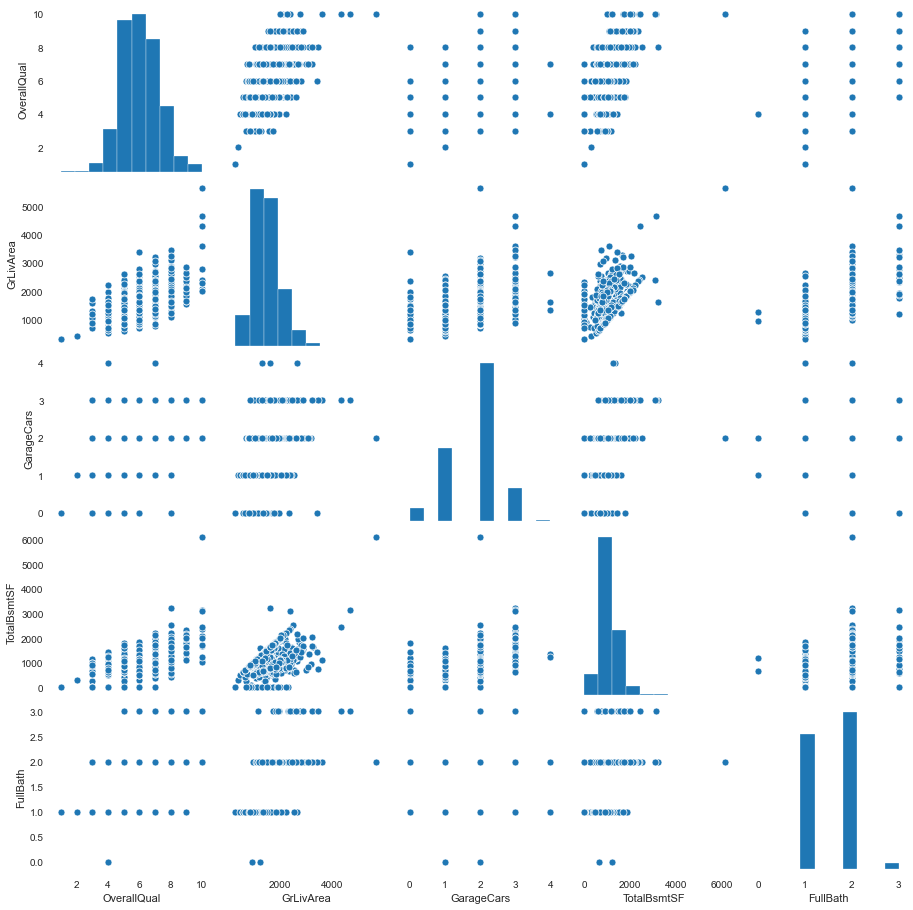

In [76]:
sns.pairplot(X_train5.drop(columns='const'))

<Figure size 576x396 with 0 Axes>

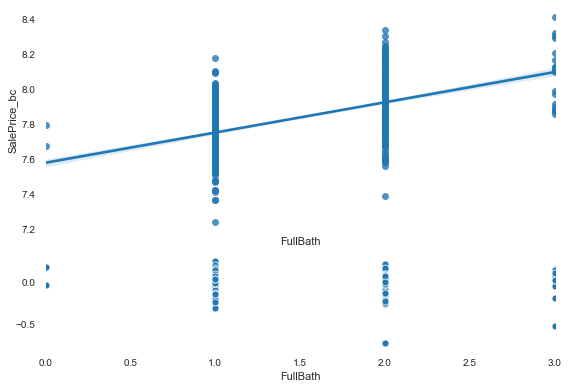

In [77]:
plt.clf()
f, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [5, 2]})
sns.regplot(x=X_train5['FullBath'], y=y_train, ax=axes[0])
sns.scatterplot(x=X_train5.FullBath, y=result5.resid, ax=axes[1])
f.tight_layout()

((array([-3.20357641, -2.9388231 , -2.79110922, ...,  2.79110922,
          2.9388231 ,  3.20357641]),
  array([-0.73250503, -0.53385278, -0.31673837, ...,  0.18824603,
          0.20689311,  0.24034212])),
 (0.06663686423781705, -1.770232670864806e-13, 0.9456888313617946))

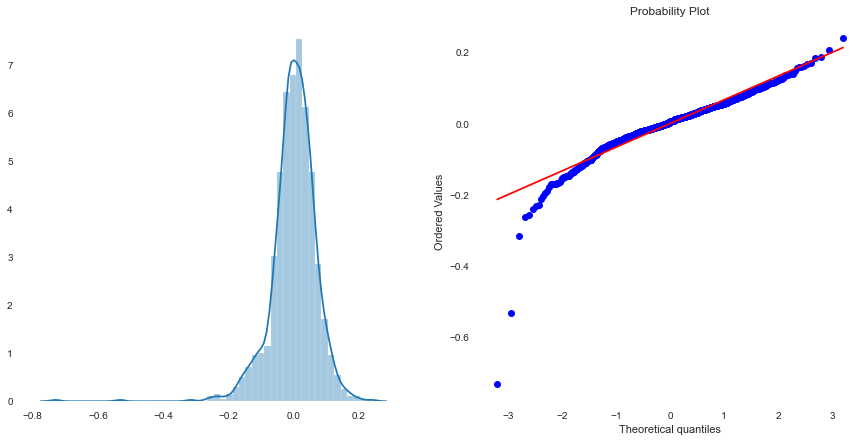

In [78]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.distplot(result5.resid)
plt.subplot(1,2,2)
stats.probplot(result5.resid, dist=stats.norm, plot=plt)

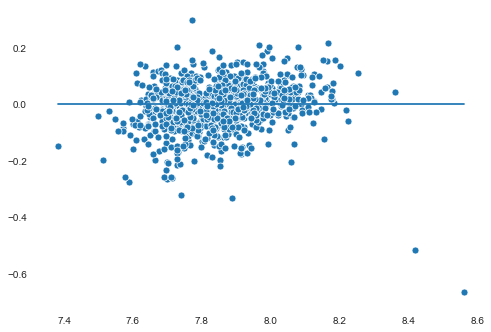

In [79]:
sns.scatterplot(x=result5.fittedvalues, y=result.resid)
sns.lineplot(x=result5.fittedvalues, y=0)

## Step 6 

In [86]:
X_train6 = sm.add_constant(X_train[['OverallQual','GrLivArea', 'GarageCars', 'TotalBsmtSF', 'YearRemodAdd']])
model6 = sm.OLS(endog=y_train, exog=X_train6)
result6 = model5.fit()

In [87]:
pd.Series([sms_outliers.variance_inflation_factor(exog = np.array(X_train6), exog_idx=i)
           for i in range(X_train6.shape[1])
          ], index=X_train6.columns)

const           12851.681173
OverallQual         2.427505
GrLivArea           1.680981
GarageCars          1.640096
TotalBsmtSF         1.465335
YearRemodAdd        1.441494
dtype: float64

In [88]:
result6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           SalePrice_bc   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     735.4
Date:                Thu, 28 May 2020   Prob (F-statistic):               0.00
Time:                        15:13:27   Log-Likelihood:                 1262.4
No. Observations:                1021   AIC:                            -2513.
Df Residuals:                    1015   BIC:                            -2483.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.2931      0.010    709.167      0.000       7.273       7.313
OverallQual     0.0461      0.002     19.244      0.000       0.041       0.051
GrLivArea    6.149e-05   5.89e-06     10.446      0.000    4.99e-05     7.3e-05
GarageCars      0.0496      0.004     12.593      0.000       0.042       0.057
TotalBsmtSF  5.182e-05   5.97e-06      8.676      0.000    4.01e-05    6.35e-05
FullBath        0.0221      0.006      3.929      0.000       0.011       0.033
==============================================================================
Omnibus:                      531.432   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10469.235
Skew:                          -1.930   Prob(JB):                         0.00
Kurtosis:                      18.205   Cond. No.                     9.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

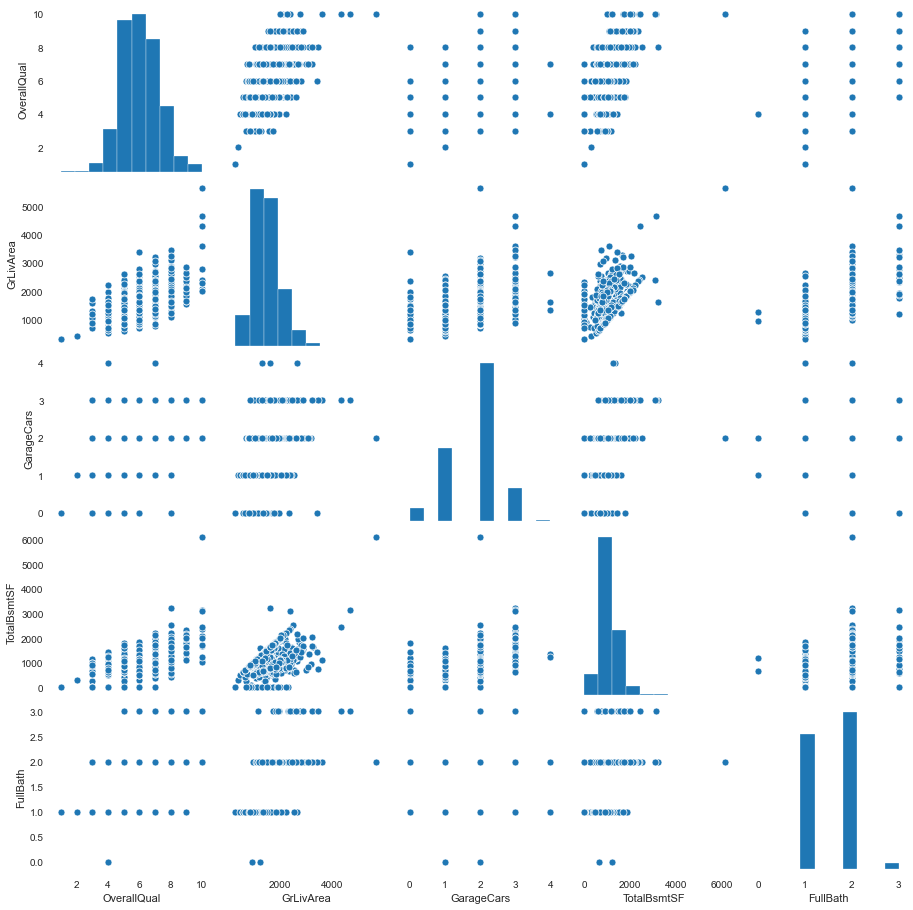

In [76]:
sns.pairplot(X_train5.drop(columns='const'))

<Figure size 576x396 with 0 Axes>

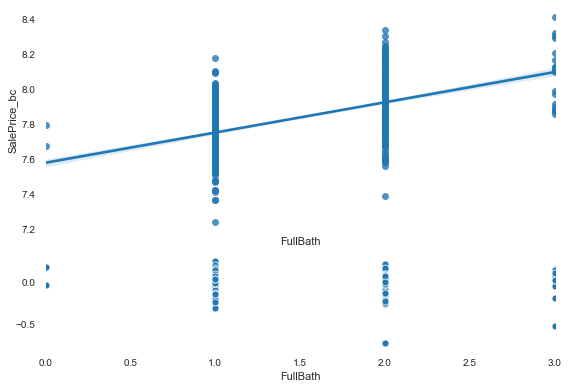

In [77]:
plt.clf()
f, axes = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [5, 2]})
sns.regplot(x=X_train5['FullBath'], y=y_train, ax=axes[0])
sns.scatterplot(x=X_train5.FullBath, y=result5.resid, ax=axes[1])
f.tight_layout()

((array([-3.20357641, -2.9388231 , -2.79110922, ...,  2.79110922,
          2.9388231 ,  3.20357641]),
  array([-0.73250503, -0.53385278, -0.31673837, ...,  0.18824603,
          0.20689311,  0.24034212])),
 (0.06663686423781705, -1.770232670864806e-13, 0.9456888313617946))

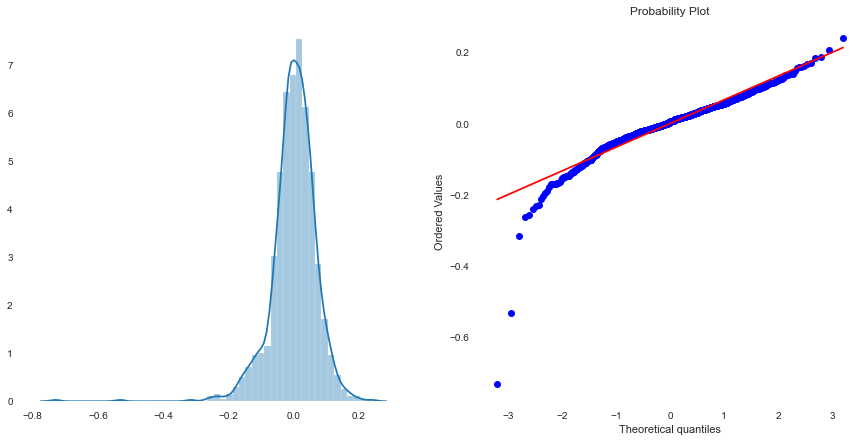

In [78]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.distplot(result5.resid)
plt.subplot(1,2,2)
stats.probplot(result5.resid, dist=stats.norm, plot=plt)

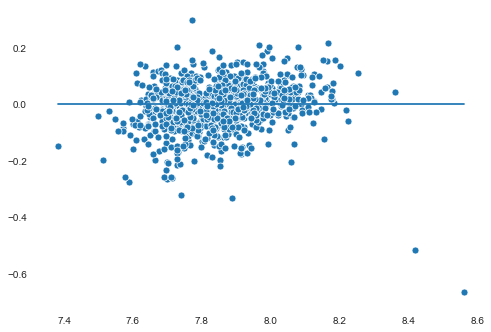

In [79]:
sns.scatterplot(x=result5.fittedvalues, y=result.resid)
sns.lineplot(x=result5.fittedvalues, y=0)

## Weighted Least Squares Trial 

In [52]:
result = sm.WLS(endog=train0.SalePrice, exog=sm.add_constant(train0.OverallQual), weights= 1/train0.OverallQual).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.621
Model:                            WLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     2390.
Date:                Thu, 07 May 2020   Prob (F-statistic):          1.47e-309
Time:                        19:23:55   Log-Likelihood:                -17729.
No. Observations:                1460   AIC:                         3.546e+04
Df Residuals:                    1458   BIC:                         3.547e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -6.447e+04   4872.279    -13.231      0.000    -7.4e+04   -5.49e+04
OverallQual  4.023e+04    822.951     48.888      0.000    3.86e+04    4.18e+04
==============================================================================
Omnibus:                      483.810   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2713.887
Skew:                           1.434   Prob(JB):                         0.00
Kurtosis:                       9.032   Cond. No.                         25.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

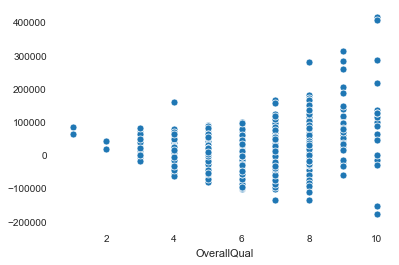

In [53]:
sns.scatterplot(x=train0.OverallQual, y=result.resid)